In [1]:
from matplotlib.pyplot import show as show_static
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import distinctipy
import glob

from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import Panel, Tabs, RangeSlider, CustomJS, Column, Row, ColumnDataSource, CategoricalColorMapper
from bokeh.plotting import output_file, save

sys.path.append('../../')
from utils import dataframe_utils

In [2]:
def csv_files_to_df(files: list):

    combined_df = None

    for f in files:

        if combined_df is None:
            combined_df = pd.read_csv(f)
            continue

        curr_df = pd.read_csv(f)

        combined_df = pd.concat([combined_df, curr_df], ignore_index=True)

    return combined_df

In [3]:
def compute_fraction_clusters_enriched(row):
    return row['nenriched_clusters'] / (row['nclusters'])

In [4]:
def smallest_unit(number):
    # Convert the number to a string to handle decimal places
    num_str = str(number)
    
    # Find the position of the decimal point
    decimal_pos = num_str.find('.')
    
    # If there's no decimal point, return 1 (for integers)
    if decimal_pos == -1:
        return 1
    
    # Calculate the length of the fractional part
    fractional_length = len(num_str) - decimal_pos - 1
    
    # Calculate the smallest unit
    smallest_unit = 10 ** (-fractional_length)
    
    return smallest_unit

In [5]:
def rgb_to_hex(rgb):
    """
    Convert RGB tuple to hexadecimal color code.
    """
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

In [6]:
def save_parameter_comparison_plot(df_stats: pd.DataFrame, metric_colors_dict: dict, out_file_name='clustering_analysis.html'):

    # resource: https://malouche.github.io/notebooks/scatter_bokeh2.html
    # PLOT 1

    tabs = []

    bokeh_data_dict = {}

    bokeh_data_dict['METRIC COMPARISON: UNFILTERED'] = df_stats

    filter_cols = [col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

    bokeh_data_dict['METRIC COMPARISON: FILTERED (10 < mean_cluster_size < 40) (10 < median_cluster_size < 40)'] = df_stats.loc[
        # (df_stats['metric'] == 'cosine') &
        # (df_stats['nns'] == 3) & 
        # (df_stats['parameter'] == 0.405) & 

        (df_stats['mean_cluster_size'] > 10) &
        (df_stats['median_cluster_size'] > 10) &
        (df_stats['mean_cluster_size'] < 40) &
        (df_stats['median_cluster_size'] < 40) &
        # (df_stats['nenriched_cluster_genes'] > 7000) &
        # (df_stats['modularity'] > 0.4) &

        (df_stats['dimensionality'] == 'baseline') &
        (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats['clustering'] == 'leiden_cpm') &
        (df_stats['partition_type'] == 'EXP')
    ]

    bokeh_x = 'modularity'
    bokeh_y = 'nenriched_clusters'
    # bokeh_y = 'fraction_clusters_enriched'
    color_column = 'metric'  # Column to use for coloring the points

    axis_padding = 0.05
    x_min, x_max = df_stats[bokeh_x].min() - axis_padding * df_stats[bokeh_x].min(), df_stats[bokeh_x].max() + axis_padding * df_stats[bokeh_x].max()
    y_min, y_max = df_stats[bokeh_y].min() - axis_padding * df_stats[bokeh_y].min(), df_stats[bokeh_y].max() + axis_padding * df_stats[bokeh_y].max()

    for tab_name, bokeh_df in bokeh_data_dict.items():

        p = figure(plot_width=1000, plot_height=800, title='HOVER OVER POINTS TO SHOW DATA. CLICK ON METRICS IN THE LEGEND TO HIDE THEM.', sizing_mode='stretch_both', x_range=(x_min, x_max), y_range=(y_min, y_max))

        for val in sorted(bokeh_df[color_column].unique()):
            col_df=bokeh_df.loc[(bokeh_df[color_column]==val)]
            p.scatter(bokeh_x, bokeh_y, size=3, color=metric_colors_dict[val], legend_label=val, source=col_df)

        hover = HoverTool(tooltips=[
            ('Partition Type', '@partition_type'),
            ('Dimensionality', '@dimensionality'),
            ('Metric', '@metric'),
            ('Graph', '@graph'),
            ('Nearest Neighbors', '@nns'),
            ('Clustering', '@clustering'),
            ('Parameter', '@parameter'),
            ('Silhouette Score', '@silhouette_score'),
            ('Modularity', '@modularity'),
            ('Number of Clusters', '@nclusters'),
            ('Mean Cluster Size', '@mean_cluster_size'),
            ('Median Cluster Size', '@median_cluster_size'),
            ('Standard Deviation of Cluster Size', '@sd_cluster_size'),
            ('Number of Enriched Clusters', '@nenriched_clusters'),
            ('Mean Enriched Cluster Size', '@mean_enriched_cluster_size'),
            ('Median Enriched Cluster Size', '@median_enriched_cluster_size'),
            ('Standard Deviation of Enriched Cluster Size', '@sd_enriched_cluster_size'),
            ('Number of Enriched Cluster Genes', '@nenriched_cluster_genes'),
            ('Fraction of Clusters Enriched', '@fraction_clusters_enriched'),
        ])
        p.add_tools(hover)

        p.legend.click_policy="hide"
        p.legend.location = "bottom_left"

        p.xaxis.axis_label = bokeh_x
        p.yaxis.axis_label = bokeh_y

        p.min_border = 100

        tabs.append(Panel(child=p, title=tab_name))

    plot_tabs1 = [t for t in tabs]


    # PLOT 2

    tabs = []

    bokeh_data_dict = {}

    bokeh_data_dict['DYNAMIC FILTERING: UNFILTERED'] = df_stats

    filter_cols = [col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

    bokeh_data_dict['DYNAMIC FILTERING: FILTERED (10 < mean_cluster_size < 40) (10 < median_cluster_size < 40)'] = df_stats.loc[
        # (df_stats['metric'] == 'cosine') &
        # (df_stats['nns'] == 3) & 
        # (df_stats['parameter'] == 0.405) & 

        (df_stats['mean_cluster_size'] > 10) &
        (df_stats['median_cluster_size'] > 10) &
        (df_stats['mean_cluster_size'] < 40) &
        (df_stats['median_cluster_size'] < 40) &
        # (df_stats['nenriched_cluster_genes'] > 7000) &
        # (df_stats['modularity'] > 0.4) &

        (df_stats['dimensionality'] == 'baseline') &
        (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats['clustering'] == 'leiden_cpm') &
        (df_stats['partition_type'] == 'EXP')
    ]

    bokeh_x = 'modularity'
    bokeh_y = 'nenriched_clusters'
    # bokeh_y = 'fraction_clusters_enriched'
    color_column = 'metric'  # Column to use for coloring the points

    axis_padding = 0.05
    x_min, x_max = df_stats[bokeh_x].min() - axis_padding * df_stats[bokeh_x].min(), df_stats[bokeh_x].max() + axis_padding * df_stats[bokeh_x].max()
    y_min, y_max = df_stats[bokeh_y].min() - axis_padding * df_stats[bokeh_y].min(), df_stats[bokeh_y].max() + axis_padding * df_stats[bokeh_y].max()

    color_mapper = CategoricalColorMapper(factors=list(metric_colors_dict.keys()), palette=list(metric_colors_dict.values()))

    for tab_name, bokeh_df in bokeh_data_dict.items():

        bokeh_data_source = ColumnDataSource(bokeh_df)

        sliders = {}


        for variable in filter_cols:

            slider_start = bokeh_df[variable].min()
            slider_end = bokeh_df[variable].max()

            if slider_start == slider_end:
                slider_end += smallest_unit(slider_end)
            
            sliders[variable] = RangeSlider(start=slider_start,
                                                end=slider_end,
                                                value=(slider_start, slider_end),
                                                step=smallest_unit(bokeh_df[variable].max()),
                                                title=f"{variable} range")


        p = figure(plot_width=1000, plot_height=800, title='HOVER OVER POINTS TO SHOW DATA. USE THE SLIDERS TO FILTER THE PARTITIONS.', sizing_mode='stretch_both', x_range=(x_min, x_max), y_range=(y_min, y_max))

        p.circle(
                x=bokeh_x,
                y=bokeh_y,
                source=bokeh_data_source,
                color={'field': color_column, 'transform': color_mapper},
                size=5,
                alpha=1,
                line_color='black'
            )

        callback = CustomJS(args=dict(source=bokeh_data_source, sliders=sliders), code="""
            const data = source.data;
            const indices = [];
            const variables = Object.keys(sliders);
            
            for (let i = 0; i < data['index'].length; i++) {
                let include = true;
                
                for (const variable of variables) {
                    const slider_range = sliders[variable].value;
                    const value = data[variable][i];
                    
                    if (value < slider_range[0] || value > slider_range[1]) {
                        include = false;
                        break;
                    }
                }
                
                if (include) {
                    indices.push(i);
                }
            }
            
            source.selected.indices = indices;
            source.change.emit();
        """)

        # Attach the callback to all sliders
        for slider in sliders.values():
            slider.js_on_change('value', callback)

        # Add all sliders to a layout
        slider_layout = Column(*sliders.values())

        hover = HoverTool(tooltips=[
            ('Partition Type', '@partition_type'),
            ('Dimensionality', '@dimensionality'),
            ('Metric', '@metric'),
            ('Graph', '@graph'),
            ('Nearest Neighbors', '@nns'),
            ('Clustering', '@clustering'),
            ('Parameter', '@parameter'),
            ('Silhouette Score', '@silhouette_score'),
            ('Modularity', '@modularity'),
            ('Number of Clusters', '@nclusters'),
            ('Mean Cluster Size', '@mean_cluster_size'),
            ('Median Cluster Size', '@median_cluster_size'),
            ('Standard Deviation of Cluster Size', '@sd_cluster_size'),
            ('Number of Enriched Clusters', '@nenriched_clusters'),
            ('Mean Enriched Cluster Size', '@mean_enriched_cluster_size'),
            ('Median Enriched Cluster Size', '@median_enriched_cluster_size'),
            ('Standard Deviation of Enriched Cluster Size', '@sd_enriched_cluster_size'),
            ('Number of Enriched Cluster Genes', '@nenriched_cluster_genes'),
            ('Fraction of Clusters Enriched', '@fraction_clusters_enriched'),
        ])
        p.add_tools(hover)

        # p.legend.click_policy="hide"
        # p.legend.location = "bottom_left"

        p.xaxis.axis_label = bokeh_x
        p.yaxis.axis_label = bokeh_y

        p.min_border = 100

        slider_layout.margin = 100

        layout = Row(p, slider_layout)

        tabs.append(Panel(child=layout, title=tab_name))

    plot_tabs2 = [t for t in tabs]

    # SAVE PLOTS

    tabbed_plot = Tabs(tabs=(plot_tabs1 + plot_tabs2))

    output_file(f'./{out_file_name}')

    save(tabbed_plot)

In [7]:
microarray_data_pattern = './microarray/*'

rna_seq_data_pattern = './rna_seq/*'

microarray_stats_files = glob.glob(microarray_data_pattern)

rna_seq_stats_files = glob.glob(rna_seq_data_pattern)

microarray_stats_df = csv_files_to_df(microarray_stats_files)

rna_seq_stats_df = csv_files_to_df(rna_seq_stats_files)

In [8]:
microarray_stats_df['fraction_clusters_enriched'] = microarray_stats_df.apply(compute_fraction_clusters_enriched, axis=1)

In [9]:
microarray_stats_df['metric'].unique()

array(['manhattan', 'correlation', 'l1', 'hamming', 'braycurtis',
       'minkowski_5.0', 'minkowski_0.5', 'minkowski_4.0', 'angular',
       'minkowski_3.0', 'minkowski_2.0', 'nan_euclidean', 'canberra',
       'seuclidean', 'euclidean', 'matching', 'cityblock',
       'minkowski_1.0', 'chebyshev', 'sqeuclidean', 'cosine', 'l2'],
      dtype=object)

In [10]:
microarray_stats_df.columns

Index(['partition_type', 'dimensionality', 'metric', 'graph', 'nns',
       'clustering', 'parameter', 'silhouette_score', 'modularity',
       'nclusters', 'mean_cluster_size', 'median_cluster_size',
       'sd_cluster_size', 'max_cluster_size', 'min_cluster_size', 'ngenes',
       'nenriched_clusters', 'mean_enriched_cluster_size',
       'median_enriched_cluster_size', 'sd_enriched_cluster_size',
       'max_enriched_cluster_size', 'min_enriched_cluster_size',
       'nenriched_cluster_genes', 'datetime',
       'max_fraction_same_cluster_MCMsubset.tsv',
       'max_fraction_same_cluster_ProteosomeSubset.tsv',
       'max_fraction_same_cluster_Histone_subset.tsv',
       'max_fraction_same_cluster_MucocystSubsets.tsv',
       'max_fraction_same_cluster_RibosomalSubset.tsv',
       'fraction_clusters_enriched'],
      dtype='object')

In [11]:
{col: type(microarray_stats_df[col].values[0]) for col in list(microarray_stats_df.columns)}

{'partition_type': str,
 'dimensionality': str,
 'metric': str,
 'graph': str,
 'nns': numpy.int64,
 'clustering': str,
 'parameter': numpy.float64,
 'silhouette_score': numpy.float64,
 'modularity': numpy.float64,
 'nclusters': numpy.int64,
 'mean_cluster_size': numpy.float64,
 'median_cluster_size': numpy.float64,
 'sd_cluster_size': numpy.float64,
 'max_cluster_size': numpy.int64,
 'min_cluster_size': numpy.int64,
 'ngenes': numpy.int64,
 'nenriched_clusters': numpy.int64,
 'mean_enriched_cluster_size': numpy.float64,
 'median_enriched_cluster_size': numpy.float64,
 'sd_enriched_cluster_size': numpy.float64,
 'max_enriched_cluster_size': numpy.float64,
 'min_enriched_cluster_size': numpy.float64,
 'nenriched_cluster_genes': numpy.int64,
 'datetime': str,
 'max_fraction_same_cluster_MCMsubset.tsv': numpy.float64,
 'max_fraction_same_cluster_ProteosomeSubset.tsv': numpy.float64,
 'max_fraction_same_cluster_Histone_subset.tsv': numpy.float64,
 'max_fraction_same_cluster_MucocystSubsets

In [12]:
[col for col in list(microarray_stats_df.columns) if isinstance(microarray_stats_df[col].values[0], (int, float, np.int64, np.float64))]

['nns',
 'parameter',
 'silhouette_score',
 'modularity',
 'nclusters',
 'mean_cluster_size',
 'median_cluster_size',
 'sd_cluster_size',
 'max_cluster_size',
 'min_cluster_size',
 'ngenes',
 'nenriched_clusters',
 'mean_enriched_cluster_size',
 'median_enriched_cluster_size',
 'sd_enriched_cluster_size',
 'max_enriched_cluster_size',
 'min_enriched_cluster_size',
 'nenriched_cluster_genes',
 'max_fraction_same_cluster_MCMsubset.tsv',
 'max_fraction_same_cluster_ProteosomeSubset.tsv',
 'max_fraction_same_cluster_Histone_subset.tsv',
 'max_fraction_same_cluster_MucocystSubsets.tsv',
 'max_fraction_same_cluster_RibosomalSubset.tsv',
 'fraction_clusters_enriched']

In [13]:
rna_seq_stats_df['fraction_clusters_enriched'] = rna_seq_stats_df.apply(compute_fraction_clusters_enriched, axis=1)

In [14]:
rna_seq_stats_df['metric'].unique()

array(['minkowski_4.0', 'minkowski_5.0', 'matching', 'cityblock', 'l1',
       'cosine', 'l2', 'canberra', 'seuclidean', 'correlation', 'angular',
       'minkowski_3.0', 'braycurtis', 'hamming', 'manhattan', 'euclidean',
       'nan_euclidean', 'chebyshev', 'sqeuclidean', 'minkowski_0.5',
       'minkowski_2.0', 'minkowski_1.0'], dtype=object)

In [15]:
rna_seq_stats_df.columns

Index(['partition_type', 'dimensionality', 'metric', 'graph', 'nns',
       'clustering', 'parameter', 'silhouette_score', 'modularity',
       'nclusters', 'mean_cluster_size', 'median_cluster_size',
       'sd_cluster_size', 'max_cluster_size', 'min_cluster_size', 'ngenes',
       'nenriched_clusters', 'mean_enriched_cluster_size',
       'median_enriched_cluster_size', 'sd_enriched_cluster_size',
       'max_enriched_cluster_size', 'min_enriched_cluster_size',
       'nenriched_cluster_genes', 'datetime',
       'max_fraction_same_cluster_MCMsubset.tsv',
       'max_fraction_same_cluster_ProteosomeSubset.tsv',
       'max_fraction_same_cluster_Histone_subset.tsv',
       'max_fraction_same_cluster_MucocystSubsets.tsv',
       'max_fraction_same_cluster_RibosomalSubset.tsv',
       'fraction_clusters_enriched'],
      dtype='object')

In [16]:
{col: type(rna_seq_stats_df[col].values[0]) for col in list(rna_seq_stats_df.columns)}

{'partition_type': str,
 'dimensionality': str,
 'metric': str,
 'graph': str,
 'nns': numpy.int64,
 'clustering': str,
 'parameter': numpy.float64,
 'silhouette_score': numpy.float64,
 'modularity': numpy.float64,
 'nclusters': numpy.int64,
 'mean_cluster_size': numpy.float64,
 'median_cluster_size': numpy.float64,
 'sd_cluster_size': numpy.float64,
 'max_cluster_size': numpy.int64,
 'min_cluster_size': numpy.int64,
 'ngenes': numpy.int64,
 'nenriched_clusters': numpy.int64,
 'mean_enriched_cluster_size': numpy.float64,
 'median_enriched_cluster_size': numpy.float64,
 'sd_enriched_cluster_size': numpy.float64,
 'max_enriched_cluster_size': numpy.int64,
 'min_enriched_cluster_size': numpy.int64,
 'nenriched_cluster_genes': numpy.int64,
 'datetime': str,
 'max_fraction_same_cluster_MCMsubset.tsv': numpy.float64,
 'max_fraction_same_cluster_ProteosomeSubset.tsv': numpy.float64,
 'max_fraction_same_cluster_Histone_subset.tsv': numpy.float64,
 'max_fraction_same_cluster_MucocystSubsets.tsv

In [17]:
[col for col in list(rna_seq_stats_df.columns) if isinstance(rna_seq_stats_df[col].values[0], (int, float, np.int64, np.float64))]

['nns',
 'parameter',
 'silhouette_score',
 'modularity',
 'nclusters',
 'mean_cluster_size',
 'median_cluster_size',
 'sd_cluster_size',
 'max_cluster_size',
 'min_cluster_size',
 'ngenes',
 'nenriched_clusters',
 'mean_enriched_cluster_size',
 'median_enriched_cluster_size',
 'sd_enriched_cluster_size',
 'max_enriched_cluster_size',
 'min_enriched_cluster_size',
 'nenriched_cluster_genes',
 'max_fraction_same_cluster_MCMsubset.tsv',
 'max_fraction_same_cluster_ProteosomeSubset.tsv',
 'max_fraction_same_cluster_Histone_subset.tsv',
 'max_fraction_same_cluster_MucocystSubsets.tsv',
 'max_fraction_same_cluster_RibosomalSubset.tsv',
 'fraction_clusters_enriched']

In [18]:
len(rna_seq_stats_df['metric'].unique()), len(microarray_stats_df['metric'].unique())

(22, 22)

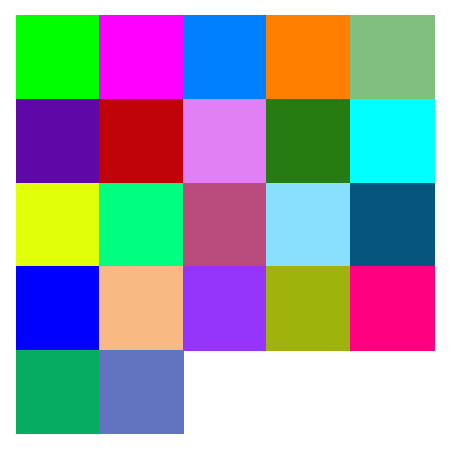

In [19]:
num_colors = len(microarray_stats_df['metric'].unique())
colors = distinctipy.get_colors(num_colors)
distinctipy.color_swatch(colors)
metric_colors_dict = {m : rgb_to_hex(colors[idx]) for idx, m in enumerate(microarray_stats_df['metric'].unique())}

In [20]:
save_parameter_comparison_plot(microarray_stats_df, metric_colors_dict=metric_colors_dict, out_file_name='microarray_stats_plot.html')
save_parameter_comparison_plot(rna_seq_stats_df, metric_colors_dict=metric_colors_dict, out_file_name='rna_seq_stats_plot.html')